In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
#WATER

def manabe_rh(rhs, p):
    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

In [4]:
#AIR

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [5]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad): #find T after convective adjustment conserving thermal energy
    thermal_energy = TE(T_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [6]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

first with LH, then with heat sink:
surface T [289.88981541] 287.23727024234887
toa radiation [60.74317169] [64.53620353]
surface radiation 175.36389102066966 168.5681710781119
atmosphere radiative cooling [-114.62071933]
latent heat [59.37947643]
sensible heat [114.70662666]
daily evaporation [2.05133417]


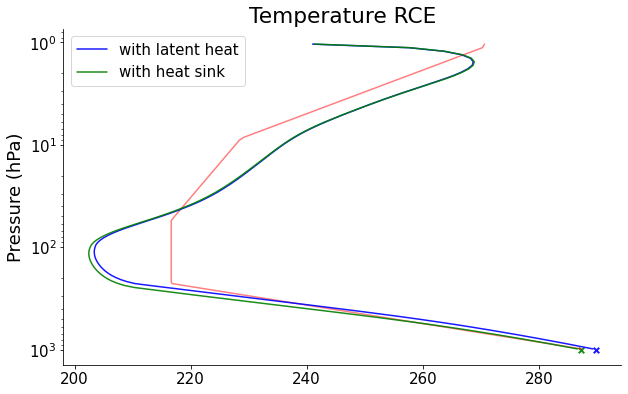

In [7]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.85),
)

RH = manabe_rh(0.8,atmosphere['plev'])

ndays = 1000
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
#    LH = 0.
    
    heat_sink = 66
    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    humidity.adjust_humidity(
                atmosphere=atmosphere,
                convection=convection,
                surface=surface,
            )

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',radiation['toa']-net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

first with LH, then with heat sink:
surface T [288.02919215] 288.02887511846154
toa radiation [62.74475356] [62.74585837]
surface radiation 169.18924521637774 169.18938262361866
latent heat 0.0
sensible heat [104.74154644]
daily evaporation 0.0


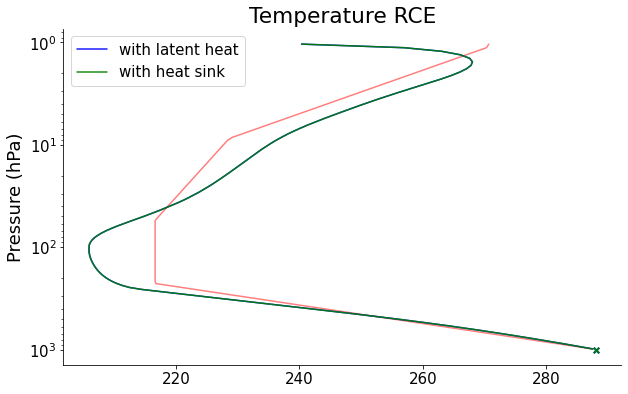

In [19]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 50
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 66
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    humidity.adjust_humidity(
                atmosphere=atmosphere,
                convection=convection,
                surface=surface,
            )

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

In [14]:
humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
humidity.attrs

{}

In [15]:
humidity.data_vars

{}